## Training Data Splitting, Subsetting, and Saving

This notebook is for preparing different subsets of the whole ABEA dataset for training runs. It performs the following:
- Reload all ABEA annotations
- Save a df to a .JSONL file (for Doccano upload)
- Spilts a df into 10-fold cross validation subsets and then writes them to .txt files in a given location
- Creates subsets from the whole df baed on certain criteria e.g. "only 1 aspect term", or "aspect terms where the total character count is less than 40", ... 

Note:
The original annotations are very complex where reasoning is ambiguous and the annotation lengths are highly varied, so several tests were run on different subsets of the whole dataset to test the training outcomes. 

### Setup

In [1]:
import ast                                                              # A Python module that helps to process trees of the Python abstract syntax grammar
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [2]:
# functions to reformat data in GRACE Format

def process_text(text, labels):
    words = text.split()
    indices = []
    start = 0
    for word in words:
        end = start + len(word)
        indices.append((start, end))
        start = end + 1  # +1 for the space or newline character

    formatted_text = []
    # reformat the lists which are stored as strings back into list formats
    labels = ast.literal_eval(labels)

    for i, (word, (start_idx, end_idx)) in enumerate(zip(words, indices)):
        label = "O O O"
        for label_range in labels:
            # a start index of -2 indicates that the label is "none"
            if start == -2:
                label = "O O O"
            else:
                range_start, range_end, emotion = label_range
                if start_idx >= range_start and end_idx <= range_end:
                    if start_idx == range_start:
                        label = f"B_AP {emotion.upper()} B_AP+{emotion.upper()}"
                    else:
                        label = f"I_AP {emotion.upper()} I_AP+{emotion.upper()}"
                    break
        formatted_text.append(f"{word} - - {label}")

    return formatted_text

def format_dataframe(df):
    all_formatted_texts = []
    for _, row in df.iterrows():
        formatted_text = process_text(row['text'], row['label'])
        all_formatted_texts.extend(formatted_text)
        all_formatted_texts.append("")  # Empty row between tweets

    return "\n".join(all_formatted_texts)

### Re-Load All ABEA Annotations

In [4]:
df = pd.read_csv("Data/Training Data/Refined Annotations/prepared_emotions.csv")
print(len(df))
df.head()


2625


,Unnamed: 0,id,text,message_id,label,Comments
0,0,2767,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, 'Happiness'], [87, 112, 'Happiness']]",[]
1,1,2768,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[57, 62, 'Anger'], [225, 235, 'Anger']]",[]
2,2,2769,I can't even: Gunfire erupts after a high scho...,1532901446114365440,"[[14, 21, 'Sadness'], [81, 94, 'Sadness']]",[]
3,3,2770,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, 'Happiness']]",[]
4,4,2771,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[348, 352, 'Happiness'], [408, 413, 'Happines...",[]


In [5]:
print(df['label'].dtype)
print(len(df.loc[0, 'label']))

object
47


### Either turn the Label Column into a List Format or a String Format

In [25]:
# turn into list format 

import ast

# Convert the 'label' column from string to actual list
df['label'] = df['label'].apply(ast.literal_eval)

print(df['label'].dtype)
# check that the label column is now in the correct list format
print(len(df.loc[0, 'label']))

object
2


In [8]:
# turn into string format

df['label'] = df['label'].astype(str)

print(df['label'].dtype)

object


### Save DF to .JSONL File for Doccano

In [24]:
# drop all other columns
df = df[['message_id', 'text', 'label']]
df.head()

,message_id,text,label
0,1524255702851620864,Proud to receive an A+ rating from th Nevada F...,"[[20, 29, Happiness], [92, 112, Happiness]]"
1,1323323443446747136,@AnotherJay @mayor_anderson @BorisJohnson My f...,"[[225, 235, Anger]]"
2,1532901446114365440,I can't even: Gunfire erupts after a high scho...,"[[14, 21, Fear], [89, 94, Sadness]]"
3,1356204586806222848,@codefknblack I had a good gun play session th...,"[[27, 43, Happiness]]"
4,1333825902220881920,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,"[[353, 357, Happiness], [386, 392, Happiness]]"


In [21]:
filepath = "whole_dataset_labeled.jsonl"
# os.makedirs(os.path.dirname(filepath), exist_ok=True)

with open(filepath, "w") as f:
    f.write(df.to_json(orient='records', lines=True))
    
    # Data\Training Data\0 - Raw Input Data for Annotations\2 - Annotated Data for Revision in JSONL Format

### Simple Train, Validation, Testing Split + Save to  GRACE Format


80% allocated to training + validation, further split this to have 90% for training and 10% for validation. This results in 72% of the data being used for training, 8% for validation, and 20% for testing.

In [9]:
# optionally apply some filtering criteria
# df = df[df['label'].apply(lambda x: len(x) == 1)]
df = df[df['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 30)]

print(len(df))

# re-convert into string format
df['label'] = df['label'].astype(str)


2146


In [35]:
# add a column for POS tagging
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# Ensure that you have the required nltk resources downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos = []

for _, row in df.iterrows():
    
    pos_row = []
    
    for label in row['label']:

        # Extract the aspect term using character positions
        start, end, _ = label
        aspect_term = row['text'][start:end+1]
        
        # Tokenize the aspect term
        tokens = word_tokenize(aspect_term)
        # POS tagging
        tagged_tokens = nltk.pos_tag(tokens)
        if len(tagged_tokens) > 0:
          
            pos_row.append(tagged_tokens[0][1])

    pos.append(pos_row)

print(pos[:5])
print(len(pos))

df['POS'] = pos

# Define the noun tags
noun_tags = {'NN', 'NNP', 'NNS'}

# Filter rows where all POS tags are noun tags
df = df[df['POS'].apply(lambda x: all(tag in noun_tags for tag in x))]

# re-convert into string format
df['label'] = df['label'].astype(str)

print(len(df))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[['NNP', 'PRP$'], ['NNP', 'NN'], ['NN', 'JJ'], ['JJ'], ['PRP', 'NN']]
2625
1402


In [36]:
df.head()

,Unnamed: 0,id,text,message_id,label,Comments,POS
1,1,2768,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[57, 62, 'Anger'], [225, 235, 'Anger']]",[],"[NNP, NN]"
5,5,2772,@myhairynipples @SkySportsPL Drogba you prick,1302449973204746240,"[[29, 35, 'Anger']]",[],[NN]
6,6,2773,"@SandraKobelt @MailOnline A lot more than 13, ...",1524641627184132096,"[[50, 74, 'None']]",[],[NN]
9,9,2776,The @SDSU Police Department and San Diego Fire...,1567966037509025792,"[[78, 90, 'None']]",[],[NN]
10,10,2777,"Wind 7.6 mph SW. Barometer 1004.2 hPa, Falling...",1322973089517445120,[],[],[]


In [37]:
# Split into 80% for training + validation and 20% for testing
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
# train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=35, shuffle=True)

# Split the 80% into training and validation (90% for training, 10% for validation)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=1, shuffle=True)
 
# Now you have three subsets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Testing set size: {len(test_df)}")

# refromat into GRACE format (one word per row with label)
formatted_train = format_dataframe(train_df)
formatted_trial = format_dataframe(val_df)
formatted_test = format_dataframe(test_df)


# Write the output to a .txt file
# file_train = f"GRACE/data/testing_train.txt"
# file_trial = f"GRACE/data/testing_trial.txt"
# file_test = f"GRACE/data/testing_test.gold.txt"
file_train = f"GRACE/data/refined_nouns_train.txt"
file_trial = f"GRACE/data/refined_nouns_trial.txt"
file_test = f"GRACE/data/refined_nouns_test.gold.txt"

with open(file_train, 'w') as file:
    file.write('-DOCSTART-\n\n')
    file.write(formatted_train)

with open(file_trial, 'w') as file:
    file.write('-DOCSTART-\n\n')
    file.write(formatted_trial)

with open(file_test, 'w') as file:
    file.write('-DOCSTART-\n\n')
    file.write(formatted_test)
 

Training set size: 896
Validation set size: 225
Testing set size: 281


### 10-fold Cross Validation Data Split

In [6]:
# Prepare KFold with 10 splits
kf = KFold(n_splits=10, random_state=32, shuffle=True)

# This dictionary will store the indices for each fold
fold_indices = {'train': [], 'trial': [], 'test': []}

# Split the data into folds and collect the indices
for fold, (train_val_index, test_index) in enumerate(kf.split(df)):
    # Here we further split the train_val set into train and trial(validation)
    # We'll take 90% of the train_val set as train and 10% as trial
    train_val_split = KFold(n_splits=10, random_state=1, shuffle=True)
    train_index, trial_index = next(train_val_split.split(train_val_index))
    
    # Actually getting the indices of train and trial from the main df
    train_indices = df.iloc[train_val_index].iloc[train_index].index
    trial_indices = df.iloc[train_val_index].iloc[trial_index].index
    
    # Save the indices in the dictionary
    fold_indices['train'].append(train_indices)
    fold_indices['trial'].append(trial_indices)
    fold_indices['test'].append(test_index)

In [9]:
# dictionary to hold the subset dataframes for each fold.
fold_dataframes = {
    'train': [],
    'trial': [],
    'test': []
}

# For each fold create subset dataframes
for fold in range(10):
    train_indices = fold_indices['train'][fold]
    trial_indices = fold_indices['trial'][fold]
    test_indices = fold_indices['test'][fold]

    # Extract the subsets from the DataFrame
    train_df = df.loc[train_indices]
    trial_df = df.loc[trial_indices]
    test_df = df.loc[test_indices]

    # Append the subsets to the fold_dataframes dictionary
    fold_dataframes['train'].append(train_df)
    fold_dataframes['trial'].append(trial_df)
    fold_dataframes['test'].append(test_df)

    
for i in range(10):
    # Get the DataFrames for this fold
    train_df = fold_dataframes['train'][i]
    trial_df = fold_dataframes['trial'][i]
    test_df = fold_dataframes['test'][i]

    print(f"{i}:\tTrain: {len(train_df)},\tTrial: {len(trial_df)},\tTest:{len(test_df)}")

    # refromat into GRACE format (one word per row with label)
    formatted_train = format_dataframe(train_df)
    formatted_trial = format_dataframe(trial_df)
    formatted_test = format_dataframe(test_df)


    # Write the output to a .txt file
    file_train = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_train.txt"
    file_trial = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_trial.txt"
    file_test = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_test.gold.txt"

    with open(file_train, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_train)

    with open(file_trial, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_trial)

    with open(file_test, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_test)



0:	Train: 2125,	Trial: 237,	Test:263
1:	Train: 2125,	Trial: 237,	Test:263
2:	Train: 2125,	Trial: 237,	Test:263
3:	Train: 2125,	Trial: 237,	Test:263
4:	Train: 2125,	Trial: 237,	Test:263
5:	Train: 2126,	Trial: 237,	Test:262
6:	Train: 2126,	Trial: 237,	Test:262
7:	Train: 2126,	Trial: 237,	Test:262
8:	Train: 2126,	Trial: 237,	Test:262
9:	Train: 2126,	Trial: 237,	Test:262


### Create Subsets for further Testing with Tweets that have Short Aspect Terms

In [16]:
import ast

# Convert the 'label' column from string to actual list
df['label'] = df['label'].apply(ast.literal_eval)

# check that the label column is now in the correct list format
print(len(df.loc[0, 'label']))

2


#### Subset 1: Only one aspect term

In [12]:
# create subset that filters for only those rows where there is just one labelled item
subset1 = df[df['label'].apply(lambda x: len(x) == 1)]
print(len(subset1))

1956


In [15]:
from sklearn.model_selection import train_test_split

# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset1_train_val, subset1_test = train_test_split(subset1, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset1_train, subset1_trial = train_test_split(subset1_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

#### Subset 2: Aspect terms where the total character count amounts to less than 40

In [14]:
subset2 = df[df['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 40)]
print(len(subset2))

2479


In [16]:
# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset2_train_val, subset2_test = train_test_split(subset2, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset2_train, subset2_trial = train_test_split(subset2_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

In [23]:
print(len(subset1_test))
print(len(subset1_trial))
print(len(subset1_train))

196
196
1564


#### Subset 3: Aspect Terms where the total character count amounts to less than 20

In [28]:
subset3 = df[df['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 20)]
print(len(subset3))

2023


In [29]:
# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset3_train_val, subset3_test = train_test_split(subset3, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset3_train, subset3_trial = train_test_split(subset3_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

print(len(subset3_test))
print(len(subset3_trial))
print(len(subset3_train))

203
203
1617


#### Subset 4: Aspect Terms where the total character count amounts to less than 10

In [31]:
subset4 = df[df['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 10)]
print(len(subset4))

1485


In [32]:
# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset4_train_val, subset4_test = train_test_split(subset4, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset4_train, subset4_trial = train_test_split(subset4_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

print(len(subset4_test))
print(len(subset4_trial))
print(len(subset4_train))

149
149
1187


#### Subset5: Remove the "none" rows from subset

In [36]:
df.head(10)

,id,text,message_id,label,Comments
0,25334,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, Happiness], [92, 112, Happiness]]",[]
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[225, 235, Anger]]",[]
2,25336,I can't even: Gunfire erupts after a high scho...,1532901446114365440,"[[14, 21, Fear], [89, 94, Sadness]]",[]
3,25337,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, Happiness]]",[]
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[353, 357, Happiness], [386, 392, Happiness]]",[]
5,25339,@myhairynipples @SkySportsPL Drogba you prick,1302449973204746240,"[[29, 35, Anger]]",[]
6,25340,"@SandraKobelt @MailOnline A lot more than 13, ...",1524641627184132096,"[[-2, -1, none]]",[]
7,25341,Give this a watch well worth it informative an...,1323368847748063232,"[[5, 9, Happiness]]",[]
8,25342,Can you tell we miss DofE? Getting outside one...,1322993372878020608,"[[21, 25, Happiness], [109, 131, Happiness]]",[]
9,25343,The @SDSU Police Department and San Diego Fire...,1567966037509025792,"[[191, 199, Fear]]",[]


In [44]:
subset5 = df[~df['label'].apply(lambda x: [-2, -1, 'none'] in x)]
# subset5 = subset5[subset5['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 30)]

print(len(subset5))
subset5.head()


1790


,id,text,message_id,label,Comments
0,25334,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, Happiness], [92, 112, Happiness]]",[]
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[225, 235, Anger]]",[]
2,25336,I can't even: Gunfire erupts after a high scho...,1532901446114365440,"[[14, 21, Fear], [89, 94, Sadness]]",[]
3,25337,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, Happiness]]",[]
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[353, 357, Happiness], [386, 392, Happiness]]",[]


In [42]:
# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset5_train_val, subset5_test = train_test_split(subset5, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset5_train, subset5_trial = train_test_split(subset5_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

print(len(subset5_test))
print(len(subset5_trial))
print(len(subset5_train))

135
135
1072


#### Subset 6: Without None Category and less than 30 Chars for AT

In [45]:
subset5 = df[~df['label'].apply(lambda x: [-2, -1, 'none'] in x)]
subset5 = subset5[subset5['label'].apply(lambda x: sum([item[1] - item[0] for item in x]) < 30)]

print(len(subset5))
# subset5.head()

# split proportions
test_size = 0.1  # 10% for testing
trial_size = 0.1  # 10% of the train_val for trial (validation)

# First split: Separate test set from train_val set
subset5_train_val, subset5_test = train_test_split(subset5, test_size=test_size, random_state=32, shuffle=True)

# Second split: Separate trial (validation) set from training set
adjusted_trial_size = trial_size / (1 - test_size)
subset5_train, subset5_trial = train_test_split(subset5_train_val, test_size=adjusted_trial_size, random_state=1, shuffle=True)

print(len(subset5_test))
print(len(subset5_trial))
print(len(subset5_train))

1342
135
135
1072


#### Sentence-Level Emotion Subset

A subset of the whole df with just the rows where the label contains only one emotion. That can be the case if there is just one label like this: ```[[20, 29, 'Happiness']]```, or if there are several labels, but they all have the same emotion, like this: ```[[20, 29, 'Happiness'], [92, 112, 'Happiness']]```, but NOT if there is more than one emotion, like this: ```[[14, 21, 'Fear'], [89, 94, 'Sadness'], [353, 357, 'Happiness']]```

In [17]:
df.head()

,id,text,message_id,label,Comments
0,25334,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, Happiness], [92, 112, Happiness]]",[]
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[225, 235, Anger]]",[]
2,25336,I can't even: Gunfire erupts after a high scho...,1532901446114365440,"[[14, 21, Fear], [89, 94, Sadness]]",[]
3,25337,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, Happiness]]",[]
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[353, 357, Happiness], [386, 392, Happiness]]",[]


In [18]:
def get_emotion_if_single(labels):
    # Check if the labels list is empty
    if not labels:
        print('no label')
        return None  # Return None for empty label lists

    # Extract all emotions from the labels
    emotions = [label[2] for label in labels]
    
    # Check if all elements in the emotions list are the same
    if all(emotion == emotions[0] for emotion in emotions):
        return emotions[0]  # Return the emotion name if all are the same
    else:
        return None  # Return None if there are different emotions

df_single_emotion = df
df_single_emotion.head()

,id,text,message_id,label,Comments
0,25334,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, Happiness], [92, 112, Happiness]]",[]
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[225, 235, Anger]]",[]
2,25336,I can't even: Gunfire erupts after a high scho...,1532901446114365440,"[[14, 21, Fear], [89, 94, Sadness]]",[]
3,25337,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, Happiness]]",[]
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[353, 357, Happiness], [386, 392, Happiness]]",[]


In [19]:
df_single_emotion['sent_level_emotion'] = df_single_emotion['label'].apply(get_emotion_if_single)


no label
no label
no label
no label
no label
no label
no label


In [22]:
df_single_emotion = df_single_emotion[df_single_emotion['sent_level_emotion'].notna()]
print(len(df_single_emotion))
df_single_emotion.head()

2544


,id,text,message_id,label,Comments,sent_level_emotion
0,25334,Proud to receive an A+ rating from th Nevada F...,1524255702851620864,"[[20, 29, Happiness], [92, 112, Happiness]]",[],Happiness
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,1323323443446747136,"[[225, 235, Anger]]",[],Anger
3,25337,@codefknblack I had a good gun play session th...,1356204586806222848,"[[27, 43, Happiness]]",[],Happiness
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,1333825902220881920,"[[353, 357, Happiness], [386, 392, Happiness]]",[],Happiness
5,25339,@myhairynipples @SkySportsPL Drogba you prick,1302449973204746240,"[[29, 35, Anger]]",[],Anger


In [30]:
df_single_emotion = df_single_emotion[['id', 'text', 'sent_level_emotion']]
df_single_emotion.head(20)

,id,text,sent_level_emotion
0,25334,Proud to receive an A+ rating from th Nevada F...,Happiness
1,25335,@AnotherJay @mayor_anderson @BorisJohnson My f...,Anger
3,25337,@codefknblack I had a good gun play session th...,Happiness
4,25338,@PennySpalpeen @jenfox84 @pastebbins @LucyFan4...,Happiness
5,25339,@myhairynipples @SkySportsPL Drogba you prick,Anger
6,25340,"@SandraKobelt @MailOnline A lot more than 13, ...",none
7,25341,Give this a watch well worth it informative an...,Happiness
8,25342,Can you tell we miss DofE? Getting outside one...,Happiness
9,25343,The @SDSU Police Department and San Diego Fire...,Fear
10,25344,"Wind 7.6 mph SW. Barometer 1004.2 hPa, Falling...",none


In [27]:
df_single_emotion.to_csv("Data/Training Data/2 - Data Reformatted and Split for Training/sent_level_emotions.csv")

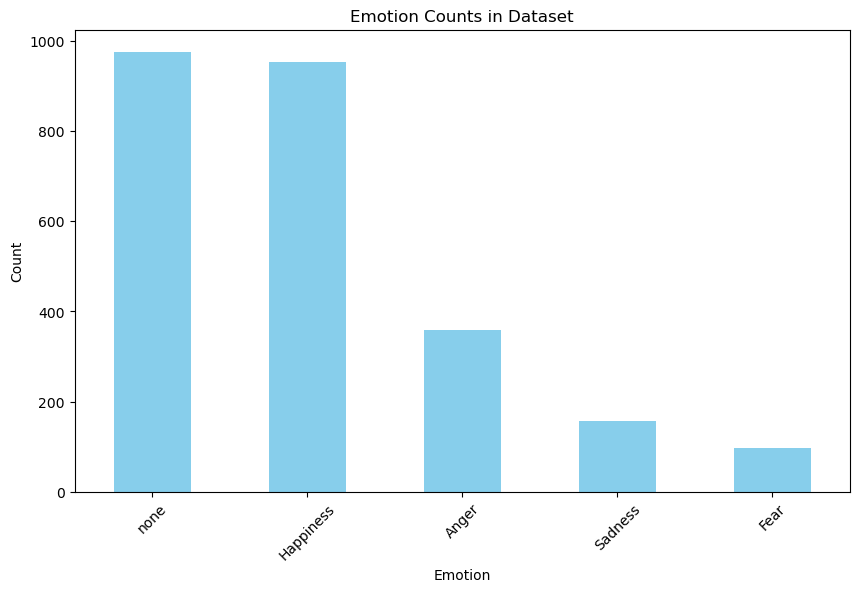

In [29]:
# Count the occurrences of each emotion in the 'sent_level_emotion' column
emotion_counts = df_single_emotion['sent_level_emotion'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
emotion_counts.plot(kind='bar', color='skyblue')  # Create a bar chart
plt.title('Emotion Counts in Sentence-level Dataset')  # Title of the chart
plt.xlabel('Emotion')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the X-axis labels for better readability
plt.show()

#### Reformat and save Subsets to GRACE Repo for Testing

In [22]:
subset_dfs = [subset2_train, subset2_trial, subset2_test, subset1_train, subset1_trial, subset1_test]
filenames = ['subset2_train', 'subset2_trial', 'subset2_test.gold', 'subset1_train', 'subset1_trial', 'subset1_test.gold']

# Process the DataFrame
for i in range(len(subset_dfs)):
    
    # load current df
    df_cur = subset_dfs[i]
    
    # turn the list format in the "label" column back into string for processing
    df_cur['label'] = df_cur['label'].apply(str)

    # reformat for GRACE format
    formatted_data = format_dataframe(df_cur)

    # Write the output to a .txt file
    output_file_path = f"GRACE/data/subsets/{filenames[i]}.txt"
    with open(output_file_path, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_data)

    print(f"Output written to {output_file_path}")

Output written to GRACE/data/subsets/subset2_train.txt
Output written to GRACE/data/subsets/subset2_trial.txt
Output written to GRACE/data/subsets/subset2_test.gold.txt
Output written to GRACE/data/subsets/subset1_train.txt
Output written to GRACE/data/subsets/subset1_trial.txt
Output written to GRACE/data/subsets/subset1_test.gold.txt


In [30]:
subset_dfs = [subset3_train, subset3_trial, subset3_test]
filenames = ['subset3_train', 'subset3_trial', 'subset3_test.gold']

# Process the DataFrame
for i in range(len(subset_dfs)):
    
    # load current df
    df_cur = subset_dfs[i]
    
    # turn the list format in the "label" column back into string for processing
    df_cur['label'] = df_cur['label'].apply(str)

    # reformat for GRACE format
    formatted_data = format_dataframe(df_cur)

    # Write the output to a .txt file
    output_file_path = f"GRACE/data/subsets/{filenames[i]}.txt"
    with open(output_file_path, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_data)

    print(f"Output written to {output_file_path}")

Output written to GRACE/data/subsets/subset3_train.txt
Output written to GRACE/data/subsets/subset3_trial.txt
Output written to GRACE/data/subsets/subset3_test.gold.txt


In [33]:
subset_dfs = [subset4_train, subset4_trial, subset4_test]
filenames = ['subset4_train', 'subset4_trial', 'subset4_test.gold']

# Process the DataFrame
for i in range(len(subset_dfs)):
    
    # load current df
    df_cur = subset_dfs[i]
    
    # turn the list format in the "label" column back into string for processing
    df_cur['label'] = df_cur['label'].apply(str)

    # reformat for GRACE format
    formatted_data = format_dataframe(df_cur)

    # Write the output to a .txt file
    output_file_path = f"GRACE/data/subsets/{filenames[i]}.txt"
    with open(output_file_path, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_data)

    print(f"Output written to {output_file_path}")

Output written to GRACE/data/subsets/subset4_train.txt
Output written to GRACE/data/subsets/subset4_trial.txt
Output written to GRACE/data/subsets/subset4_test.gold.txt


In [43]:
subset_dfs = [subset5_train, subset5_trial, subset5_test]
filenames = ['subset6_train', 'subset6_trial', 'subset6_test.gold']

# Process the DataFrame
for i in range(len(subset_dfs)):
    
    # load current df
    df_cur = subset_dfs[i]
    
    # turn the list format in the "label" column back into string for processing
    df_cur['label'] = df_cur['label'].apply(str)

    # reformat for GRACE format
    formatted_data = format_dataframe(df_cur)

    # Write the output to a .txt file
    output_file_path = f"GRACE/data/subsets/{filenames[i]}.txt"
    with open(output_file_path, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_data)

    print(f"Output written to {output_file_path}")

Output written to GRACE/data/subsets/subset6_train.txt
Output written to GRACE/data/subsets/subset6_trial.txt
Output written to GRACE/data/subsets/subset6_test.gold.txt


### 10 fold cross validation split for nouns

In [5]:
# function to read the GRACE-formatted txt file into a df with a 'text' and 'label' column.
def grace_format_to_df_cols(txt_path):

    with open(txt_path, 'r') as file:
        file_content = file.read()
    
    content_without_docstart = file_content.split('\n', 1)[1]

    # Split the content based on empty lines to get each sequence
    sequences = [seq.strip() for seq in content_without_docstart.split('\n\n') if seq.strip()]

    texts_labels = [process_sequence(seq) for seq in sequences]
    texts, labels = zip(*texts_labels)  # Unzip the texts and labels

    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    return df

# function to process each of the sequences
def process_sequence(seq):
    words = []
    labels = []
    char_index = 0  # Start from the first character
    in_label = False
    label_start = 0
    label_sentiment = ''

    for line in seq.split('\n'):
        parts = line.split()
        if len(parts) < 2:  # Skip empty lines or lines without tags
            continue
        word, tag = parts[0], parts[-1]
        words.append(word)

        # If this word starts a new label
        if 'B_AP' in tag:
            if in_label:  # End the previous label if starting a new one
                labels.append([label_start, char_index - 1, label_sentiment])
            in_label = True
            label_start = char_index
            # Determine the sentiment
            if 'FEAR' in tag:
                label_sentiment = 'FEAR'
            elif 'NONE' in tag:
                label_sentiment = 'NONE'
            elif 'HAPPINESS' in tag:
                label_sentiment = 'HAPPINESS'
            elif 'ANGER' in tag:
                label_sentiment = 'ANGER'
            elif 'SADNESS' in tag:
                label_sentiment = 'SADNESS'

        # If this word is not part of a label or starts a new label
        if 'B_AP' not in tag and 'I_AP' not in tag and in_label:
            labels.append([label_start, char_index - 1, label_sentiment])
            in_label = False

        char_index += len(word) + 1  # Update character index for next word, adding 1 for the space

    # If the last label goes till the end of the sequence
    if in_label:
        labels.append([label_start, char_index - 1, label_sentiment])

    return ' '.join(words), labels

In [9]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_trial.txt'
abea_trial = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt'
abea_train = grace_format_to_df_cols(file_path)
file_path = 'GRACE/data/same_split_as_absa/abea_w_none_clean_test.gold.txt'
abea_test = grace_format_to_df_cols(file_path)

concatenated = pd.concat([abea_trial, abea_train, abea_test], ignore_index=True)
abea_nouns = concatenated.drop_duplicates(subset=['text'])

# turn into string format

abea_nouns['label'] = abea_nouns['label'].astype(str)

print(abea_nouns['label'].dtype)

print(len(abea_nouns))
abea_nouns.head(15)

object
2592


C:\Users\chris\AppData\Local\Temp\ipykernel_63448\1448659103.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abea_nouns['label'] = abea_nouns['label'].astype(str)


,text,label
0,everybody n they momma parked on the side of c...,"[[0, 9, 'SADNESS'], [12, 22, 'SADNESS'], [73, ..."
1,"Just posted a photo @ Dylans , George Street ,...","[[14, 19, 'NONE']]"
2,Fabulous to be cycling ( virtually ) up the Pa...,"[[15, 22, 'HAPPINESS'], [44, 60, 'HAPPINESS'],..."
3,"Memorials , delegations , & flyering today in ...","[[71, 80, 'SADNESS'], [85, 93, 'SADNESS'], [10..."
4,@realsb4feelings Nothing to do with flu and co...,"[[36, 39, 'ANGER'], [44, 58, 'ANGER']]"
5,Ironically beautiful scene at Yosemite with a ...,"[[21, 26, 'HAPPINESS'], [30, 38, 'HAPPINESS'],..."
6,@MercedesAMGF1 You guys are just outstanding e...,"[[15, 23, 'HAPPINESS'], [111, 118, 'HAPPINESS'..."
7,"@Mobile_Dom Gee , lucky you ! I was so close y...","[[24, 27, 'HAPPINESS'], [76, 82, 'SADNESS']]"
8,Firmino from not scoring to not creating . . . .,"[[0, 7, 'SADNESS']]"
9,@LcfcSpencerr Never met a Leicester fan ever ....,"[[26, 39, 'NONE'], [91, 95, 'ANGER'], [107, 11..."


In [10]:
from sklearn.model_selection import KFold, train_test_split

# Prepare KFold with 10 splits
kf = KFold(n_splits=10, random_state=32, shuffle=True)

# This dictionary will store the indices for each fold
fold_indices = {'train': [], 'trial': [], 'test': []}

# Split the data into folds and collect the indices
for fold, (train_val_test_index, test_index) in enumerate(kf.split(abea_nouns)):
    # Split the train_val_test set into 80% train/validation and 20% test
    train_val_index, test_index = train_test_split(train_val_test_index, test_size=0.2, random_state=fold)

    # Further split the train_val set into 70% train and 10% validation
    train_index, trial_index = train_test_split(train_val_index, test_size=0.125, random_state=fold)

    # Get the actual indices from the data
    train_indices = abea_nouns.iloc[train_index].index
    trial_indices = abea_nouns.iloc[trial_index].index
    test_indices = abea_nouns.iloc[test_index].index

    # Save the indices in the dictionary
    fold_indices['train'].append(train_indices)
    fold_indices['trial'].append(trial_indices)
    fold_indices['test'].append(test_indices)


In [11]:

# Dictionary to hold the subset dataframes for each fold
fold_dataframes = {
    'train': [],
    'trial': [],
    'test': []
}

# For each fold, create subset dataframes
for fold in range(10):
    train_indices = fold_indices['train'][fold]
    trial_indices = fold_indices['trial'][fold]
    test_indices = fold_indices['test'][fold]

    # Extract the subsets from the DataFrame
    train_df = abea_nouns.loc[train_indices]
    trial_df = abea_nouns.loc[trial_indices]
    test_df = abea_nouns.loc[test_indices]

    # Append the subsets to the fold_dataframes dictionary
    fold_dataframes['train'].append(train_df)
    fold_dataframes['trial'].append(trial_df)
    fold_dataframes['test'].append(test_df)

# Save the data for each fold
for i in range(10):
    # Get the DataFrames for this fold
    train_df = fold_dataframes['train'][i]
    trial_df = fold_dataframes['trial'][i]
    test_df = fold_dataframes['test'][i]

    print(f"{i}:\tTrain: {len(train_df)},\tTrial: {len(trial_df)},\tTest: {len(test_df)}")

    # Reformat into GRACE format (one word per row with label)
    formatted_train = format_dataframe(train_df)
    formatted_trial = format_dataframe(trial_df)
    formatted_test = format_dataframe(test_df)

    # Write the output to a .txt file
    file_train = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_train.txt"
    file_trial = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_trial.txt"
    file_test = f"GRACE/data/same_split_as_absa/ten_fold_abea_w_none_clean/abea_w_none_clean_{i}_test.gold.txt"

    with open(file_train, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_train)

    with open(file_trial, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_trial)

    with open(file_test, 'w') as file:
        file.write('-DOCSTART-\n\n')
        file.write(formatted_test)

0:	Train: 1631,	Trial: 234,	Test: 467
1:	Train: 1631,	Trial: 234,	Test: 467
2:	Train: 1632,	Trial: 234,	Test: 467
3:	Train: 1632,	Trial: 234,	Test: 467
4:	Train: 1632,	Trial: 234,	Test: 467
5:	Train: 1632,	Trial: 234,	Test: 467
6:	Train: 1632,	Trial: 234,	Test: 467
7:	Train: 1632,	Trial: 234,	Test: 467
8:	Train: 1632,	Trial: 234,	Test: 467
9:	Train: 1632,	Trial: 234,	Test: 467
